In [1]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.tree import export_graphviz 
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols
from numpy import loadtxt


# Read csv file into a dataframe.
df = pd.read_csv('xbeta4.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Timestamp,LineID,Direction,Journey_Pattern_ID,Timeframe,Vehicle_Journey_ID,Lon,Lat,...,End_Stop,Stops_To_Travel,Time_To_Travel_Dirty,Time_To_Travel,Scheduled_Speed_Per_Stop,time_bins,Rain,Temperature,Wind_Speed,Hour_Of_Day_y
0,0,38,1357106428000000,4,0,40001,2013-01-02,4541,-6.271678,53.365372,...,59,40,1944000000,32.0,1.016949,3,0.0,5.5,14.0,23
1,1,53,1357106548000000,4,0,40001,2013-01-02,4541,-6.272670,53.360115,...,59,40,1824000000,30.0,1.016949,3,0.0,5.5,14.0,23
2,2,75,1357106707000000,4,0,40001,2013-01-02,4541,-6.265978,53.356297,...,59,40,1665000000,27.0,1.016949,3,0.0,5.5,14.0,23
3,3,91,1357106807000000,4,0,40001,2013-01-02,4541,-6.261073,53.352112,...,59,40,1565000000,26.0,1.016949,3,0.0,5.5,14.0,23
4,4,108,1357106893000000,4,0,40001,2013-01-02,4556,-6.263812,53.399124,...,52,46,2135000000,35.0,1.016949,3,0.0,5.5,14.0,23


# 1.0 Model Analysis

## 1.1 Random Forest Regression

In [2]:

y, X = dmatrices('Time_To_Travel ~ Day_Of_Week + Time_Bin_Start +  Scheduled_Speed_Per_Stop + Wind_Speed +  Temperature  + Holiday + Stops_To_Travel + Stop_Sequence', df, return_type="dataframe") 
y = np.ravel(y)
#X

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=33) 

In [4]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [5]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=10))

In [6]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [7]:
clf = GridSearchCV(pipeline, hyperparameters, cv=8)

In [8]:
clf.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
pred = clf.predict(X_test)

In [10]:
r2_score(y_test, pred)

0.97395416978214444

Good, closer to 1 the better

In [11]:
mean_squared_error(y_test, pred)

10.526136069219563

Good, closer to 0 the better.

This saves the model for later.

In [12]:
joblib.dump(clf, '../flask_app/static/rf_regressor.pkl')

['../flask_app/static/rf_regressor.pkl']

In [13]:
X_test.head()

,Intercept,Day_Of_Week,Time_Bin_Start,Scheduled_Speed_Per_Stop,Wind_Speed,Temperature,Holiday,Stops_To_Travel,Stop_Sequence
30865,1.0,3.0,9111.0,1.016949,2.0,4.9,0.0,52.0,8.0
2502,1.0,2.0,19110.0,1.016949,14.0,5.5,1.0,54.0,17.0
26233,1.0,1.0,17100.0,0.983607,2.0,0.6,0.0,55.0,35.0
40842,1.0,0.0,21000.0,0.983607,5.0,-0.6,0.0,56.0,44.0
17432,1.0,2.0,11000.0,1.016949,14.0,5.5,0.0,58.0,46.0


This can then be reloaded to be used in the flask app. As seen below.

In [14]:
clf2 = joblib.load('../flask_app/static/rf_regressor.pkl')

In [15]:
predictions = list(clf2.predict(X_test))
predictions

modified=[]

for i in predictions:
    modified.append(i)
# print(modified)

X_test["Prediction"]=0
X_test["Prediction"]=modified
X_test.head()

/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Intercept,Day_Of_Week,Time_Bin_Start,Scheduled_Speed_Per_Stop,Wind_Speed,Temperature,Holiday,Stops_To_Travel,Stop_Sequence,Prediction
30865,1.0,3.0,9111.0,1.016949,2.0,4.9,0.0,52.0,8.0,56.8
2502,1.0,2.0,19110.0,1.016949,14.0,5.5,1.0,54.0,17.0,42.7
26233,1.0,1.0,17100.0,0.983607,2.0,0.6,0.0,55.0,35.0,30.6
40842,1.0,0.0,21000.0,0.983607,5.0,-0.6,0.0,56.0,44.0,9.0
17432,1.0,2.0,11000.0,1.016949,14.0,5.5,0.0,58.0,46.0,15.9


In [16]:
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [17]:
df.shape

(120656, 45)

## To Do

Date is in the model as a variable making significant impact as cannot group random forest by dates - to confirm why it makes an impact (improves score about 7% but we should  understand is this equiv to groupby or coincidence or a proxy for events).

Getting a memory error with feature importance so for now using the linear results to guide - issue with rain: clearly important - we know that - and humidity is important, but no rain columns are making any impact. See commented out code below.

In [18]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [19]:
pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})

,feature,importance
0,Intercept,0.000000
1,Day_Of_Week,0.076326
2,Time_Bin_Start,0.212304
3,Scheduled_Speed_Per_Stop,0.005686
4,Wind_Speed,0.107589
5,Temperature,0.131450
6,Holiday,0.007452
7,Stops_To_Travel,0.112988
8,Stop_Sequence,0.346204


# Decision tree for single tree - not going to work here but gives visual of the tree structure

In [20]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

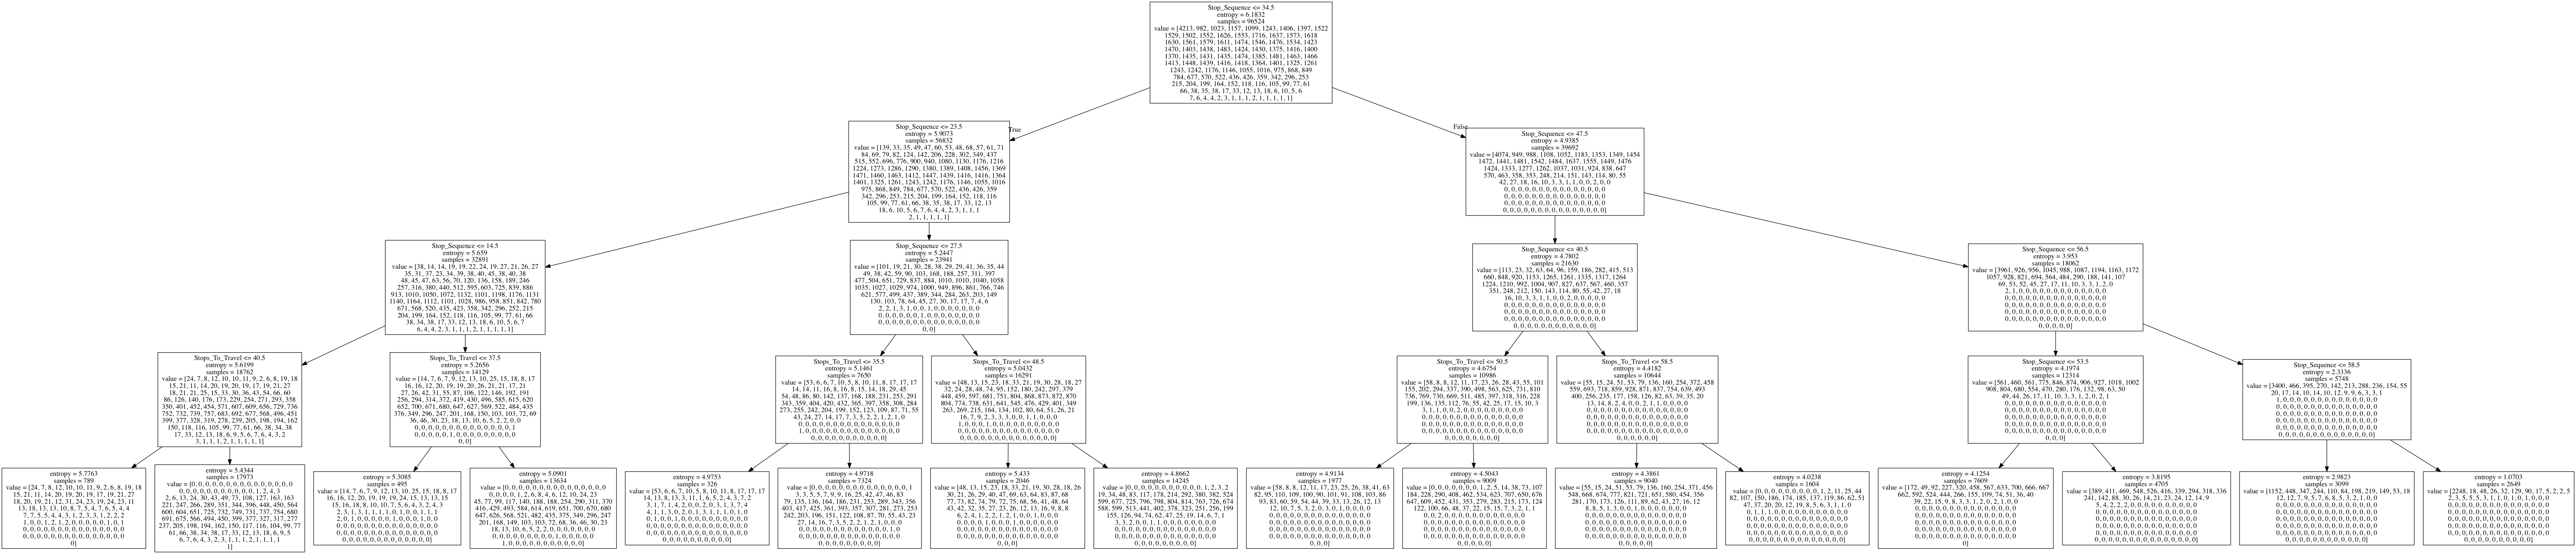

In [21]:
tree.export_graphviz(clf, out_file='tree.dot', feature_names = X_train.columns)
!dot -Tpng tree.dot > tree.png
from IPython.display import Image 
Image(filename='tree.png')

In [22]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True,show_classification_report=True, show_confussion_matrix=True):
    
    y_pred=clf.predict(X)
    
    if show_accuracy:
        print ("accuracy",metrics.accuracy_score(y, y_pred))
        
    if show_classification_report:
        print ("classification",metrics.classification_report(y,y_pred))
            
    if show_confussion_matrix:
        print ("confusion matrix",metrics.confusion_matrix(y,y_pred))
        
measure_performance(X_train,y_train,clf)

accuracy 0.0969810617049
classification              precision    recall  f1-score   support

        0.0       0.57      0.82      0.67      4213
        1.0       0.00      0.00      0.00       982
        2.0       0.00      0.00      0.00      1023
        3.0       0.12      0.47      0.19      1157
        4.0       0.00      0.00      0.00      1099
        5.0       0.00      0.00      0.00      1243
        6.0       0.00      0.00      0.00      1406
        7.0       0.00      0.00      0.00      1397
        8.0       0.09      0.48      0.15      1522
        9.0       0.00      0.00      0.00      1529
       10.0       0.00      0.00      0.00      1502
       11.0       0.00      0.00      0.00      1552
       12.0       0.00      0.00      0.00      1626
       13.0       0.00      0.00      0.00      1553
       14.0       0.06      0.06      0.06      1716
       15.0       0.09      0.50      0.15      1637
       16.0       0.00      0.00      0.00      1573
     

/Users/katerooney/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# K nearest neighbours

In [23]:
import random
import math
from numpy.random import permutation

# Randomly shuffle the index of df.
random_indices = permutation(df.index)
# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(df)/3)
# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = df.loc[random_indices[1:test_cutoff]]
# Generate the train set with the rest of the data.
train = df.loc[random_indices[test_cutoff:]]

In [24]:
x_columns = ['Scheduled_Speed_Per_Stop', 'Stops_To_Travel','Day_Of_Week', 'Time_Bin_Start', 'Wind_Speed', 'Holiday', 'Stop_Sequence', 'Temperature']

y_column = ['time_bins']

from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=5)
# Fit the model on the training data.
knn.fit(train[x_columns], train[y_column])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test[x_columns])


In [25]:
# Get the actual values for the test set.
actual = test[y_column]

# Compute the mean squared error of our predictions.
mse = (((predictions - actual) ** 2).sum()) / len(predictions)


In [26]:
mse

time_bins    0.365319
dtype: float64

# Linear model

In [27]:
import statsmodels.formula.api as sm

# Train all continuous features.
check1 = sm.ols(formula='Time_To_Travel ~  Scheduled_Speed_Per_Stop +  Stops_To_Travel + Stop_Sequence', data=df).fit()
# Print the weights learned for each feature.
print(check1.summary())

                            OLS Regression Results                            
Dep. Variable:         Time_To_Travel   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 2.304e+05
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        10:34:43   Log-Likelihood:            -4.1840e+05
No. Observations:              120656   AIC:                         8.368e+05
Df Residuals:                  120652   BIC:                         8.369e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Logistic Regression Model with Bins

In [28]:
# Training the model with original selection of four features:

logreg = sm.logit(formula='Late ~  Scheduled_Speed_Per_Stop +  Stops_To_Travel + Stop_Sequence', data=df).fit()

# Print the weights learned for each feature.
print(logreg.params)

Optimization terminated successfully.
         Current function value: 0.612669
         Iterations 7
Intercept                  -29.429073
Scheduled_Speed_Per_Stop    20.956606
Stops_To_Travel              0.163950
Stop_Sequence               -0.001952
dtype: float64
